# Junction Naming

__December 2022__

Can we find an automatic way of naming junctions?

In [1]:
import sys
import importlib
import osmnx as ox

sys.path.append("../src/")
f = importlib.import_module('03-build-junctions-graph')

# this prevents a lot of future warnings that are coming out of oxmnx
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Nodes: 648


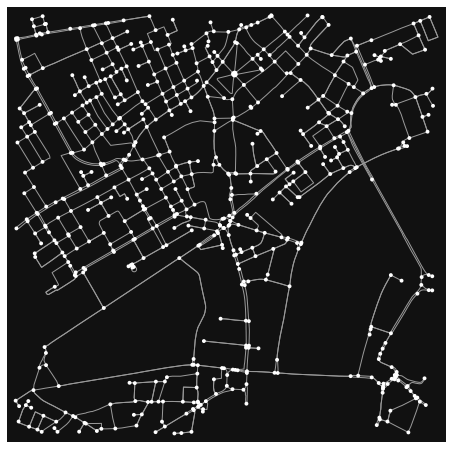

In [105]:
G1 = ox.graph_from_address(
    'London, UK',
    network_type='drive',
    dist=1000
)

print(f'Nodes: {len(G1.nodes)}')
ox.plot_graph(G1);

Nodes: 298


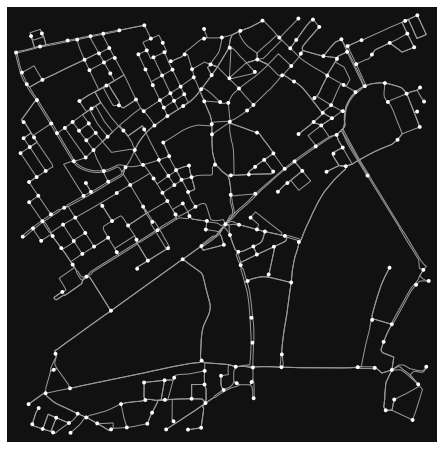

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [106]:
G2 = ox.consolidate_intersections(
    ox.project_graph(G1),
    tolerance=20,  # combines junctions within 40m
    rebuild_graph=True,
    dead_ends=False,
    reconnect_edges=True
)

print(f'Nodes: {len(G2.nodes)}')
ox.plot_graph(G2)

In [152]:
def combine_names(names):
    if type(names) == str:
        return [names]
    
    flat_names = []
    for n in names:
        if type(n) == list:
            for m in n:
                flat_names.append(m)
        else:
            flat_names.append(n)
    
    unique_names = list(set(flat_names))

    return unique_names


def list_to_string_name(names):
    names = [name for name in names if (name != '') & (name == name)]
        
    name = '-'.join(names)
    if name == '':
        name = 'Unknown'
    return name


def convert_strings_list(x):
    '''
    Function to convert a list stored in a string to a list.
    '''
    if type(x) == int:
        return [x]
    else:
        return x.strip('][').split(', ')

In [132]:
# create datafraems from G1 & G2
df_lower = (
    ox.graph_to_gdfs(
        G1,
        nodes=True,
        edges=False,
        node_geometry=True,
        fill_edge_geometry=False
    )
    .drop(columns=['highway', 'street_count'])
    .reset_index()
    .rename(columns={'y': 'lat', 'x': 'lon', 'osmid': 'osmid_original'})
)

df_higher = ox.graph_to_gdfs(
    G2,
    nodes=True,
    edges=False,
    node_geometry=True,
    fill_edge_geometry=False
)

df_higher['osmid_original'] = df_higher['osmid_original'].apply(convert_strings_list)
df_higher = df_higher.explode('osmid_original')
df_higher['osmid_original'] = df_higher['osmid_original'].astype(int)

df_higher = (
    df_higher
    .reset_index()
    .drop(columns=['x', 'y', 'street_count', 'highway', 'lon', 'lat'])
    .rename(columns={'osmid': 'osmid_cluster'})
)

# Combine datasets
df = df_lower.merge(
    df_higher,
    how='inner',
    on='osmid_original',
    suffixes=['_original', '_cluster']
)

# calculate lat, lons for clusters
cluster_coords = (
    df
    .groupby('osmid_cluster')[['lat', 'lon']]
    .mean()
    .reset_index()
    .rename(columns={'lat': 'latitude_cluster', 'lon': 'longitude_cluster'})
)

# join in
df = df.merge(
    cluster_coords,
    how='left',
    on='osmid_cluster'
)

# fill nulls with the lower level coordinate when missing
df['latitude_cluster'] = df['latitude_cluster'].fillna(df['lat'])
df['longitude_cluster'] = df['longitude_cluster'].fillna(df['lon'])

# drop some cols and rename some
df = (
    df
    .drop(
        columns=['geometry_original', 'geometry_cluster']
    )
    .reset_index()
    .rename(
        columns={
            'index': 'junction_index',
            'lat': 'latitude_junction',
            'lon': 'longitude_junction',
            'osmid_original': 'junction_id',
            'osmid_cluster': 'junction_cluster_id'
        }
    )
)

df.head()

,junction_index,junction_id,latitude_junction,longitude_junction,junction_cluster_id,latitude_cluster,longitude_cluster
0,0,107322,51.516246,-0.132866,0,51.516246,-0.132866
1,1,107324,51.515647,-0.132440,2,51.515647,-0.132440
2,2,107326,51.515137,-0.132766,4,51.515137,-0.132766
3,3,107328,51.514820,-0.132309,5,51.514820,-0.132309
4,4,107333,51.515305,-0.141966,7,51.515268,-0.142009


In [133]:
junction_names = (
    ox
    .graph_to_gdfs(G1, nodes=False)
    .reset_index()
    [['u', 'name']]
    .fillna('')
)

junction_names['name'] = junction_names['name'].apply(combine_names)

df = df.merge(
    junction_names,
    how='left',
    left_on='junction_id',
    right_on='u'
)

cluster_names = df.groupby('junction_cluster_id')['name'].apply(combine_names).reset_index()

df = df.merge(
    cluster_names,
    how='left',
    on='junction_cluster_id',
    suffixes=['', '_cluster']
)

df.head()

,junction_index,junction_id,latitude_junction,longitude_junction,junction_cluster_id,latitude_cluster,longitude_cluster,u,name
0,0,107322,51.516246,-0.132866,0,51.516246,-0.132866,107322.0,[Oxford Street]
1,1,107324,51.515647,-0.132440,2,51.515647,-0.132440,107324.0,[Soho Square]
2,1,107324,51.515647,-0.132440,2,51.515647,-0.132440,107324.0,[Soho Street]
3,2,107326,51.515137,-0.132766,4,51.515137,-0.132766,107326.0,[Soho Square]
4,3,107328,51.514820,-0.132309,5,51.514820,-0.132309,107328.0,[Frith Street]


In [171]:
df['junction_cluster_name'] = df['name_cluster'].apply(list_to_string_name)

df['name_rank'] = (
    df
    .groupby(['junction_cluster_name'])['junction_id']
    .transform('rank', method='dense')
)

df['junction_cluster_name_plus_rank'] = (
    df['junction_cluster_name'] + '-' + df['name_rank'].astype(int).astype(str)
)

(
    df
    .groupby('junction_cluster_name_plus_rank')
    ['junction_cluster_id']
    .nunique()
    .reset_index()
    .sort_values(by='junction_cluster_id')
)

,junction_cluster_name_plus_rank,junction_cluster_id
0,Abbey Orchard Street-1,1
386,Savile Row-New Burlington Street-Boyle Street-...,1
385,Sardinia Street-1,1
384,Saint Martin's Place-St. Martin's Place-Charin...,1
383,Saint Martin's Place-St. Martin's Place-Charin...,1
...,...,...
189,Haymarket-Pall Mall-Pall Mall East-5,1
190,Horse Guards Avenue-Victoria Embankment-1,1
191,Horse Guards Avenue-Whitehall Court-1,1
185,Haymarket-Pall Mall-Pall Mall East-1,1


In [174]:
df[df['junction_cluster_name'] == 'Oxford Street'][
    ['junction_cluster_id', 'junction_cluster_name_plus_rank']
].drop_duplicates()

,junction_cluster_id,junction_cluster_name_plus_rank
0,0,Oxford Street-1
98,79,Oxford Street-2
213,154,Oxford Street-3
214,1,Oxford Street-4
691,246,Oxford Street-5
1155,79,Oxford Street-6
